In [2]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install arch
! pip install pyflux
import pyflux as pf

     |████████████████████████████████| 716kB 8.9MB/s 
     |████████████████████████████████| 1.3MB 8.9MB/s 
     |████████████████████████████████| 962kB 41.4MB/s 
  Created wheel for pyflux: filename=pyflux-0.4.15-cp36-cp36m-linux_x86_64.whl size=4656516 sha256=59bef83b23763ef7e468a9a266d40f4ca08291ea4d7794c9952e2be1b5ab2087
  Stored in directory: /root/.cache/pip/wheels/36/24/09/d18fa4f926cc90598d23ebd09fb4b0fd7b3dd1d2f506b952de
Successfully built pyflux


In [3]:
!git clone https://github.com/vmeylan/machine_learning_for_finance.git

Cloning into 'machine_learning_for_finance'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 180 (delta 37), reused 41 (delta 15), pack-reused 95
Receiving objects: 100% (180/180), 87.58 MiB | 20.17 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (28/28), done.


### Data Analysis

In [0]:
data = pd.read_csv('machine_learning_for_finance/data/preprocessed_data/theta.csv').drop(['Unnamed: 0', '_INTERCEPT', '_REALIZED_VOL', '_VOL_PROXY', '_NEGATIVE_RETURNS', '_BTC_REALIZED_VOL', '_BTC_VOL_PROXY','BTC_low', 'BTC_high', 'high', 'low', '_BTC_NEGATIVE_RETURNS', 'time'], axis=1)

In [5]:
data.head()

,BTC_close,BTC_volume,_BTC_RETURNS,_TO_EXCHANGE_TRANSACTIONS,_FROM_EXCHANGE_TRANSACTIONS,_ONCHAIN_TRANSACTIONS,_ONCHAIN_VOLUME,close,volume,_RETURNS
0,9454.60,6.434511e+08,0.102112,20,55,75,4.012353e+24,0.000014,293.24,0.018458
1,10029.51,8.262557e+08,0.059030,13,52,65,2.382509e+24,0.000014,455.06,0.024568
2,10163.05,6.718616e+08,0.013227,17,74,91,1.821926e+24,0.000014,289.64,-0.012931
3,11040.00,7.879111e+08,0.082766,7,43,50,9.719927e+23,0.000015,423.71,0.089839
4,10380.06,9.898472e+08,-0.061638,4,128,132,9.691477e+24,0.000016,426.84,0.060275


In [6]:
data.columns

Index(['BTC_close', 'BTC_volume', '_BTC_RETURNS', '_TO_EXCHANGE_TRANSACTIONS',
       '_FROM_EXCHANGE_TRANSACTIONS', '_ONCHAIN_TRANSACTIONS',
       '_ONCHAIN_VOLUME', 'close', 'volume', '_RETURNS'],
      dtype='object')

In [0]:
data.loc[:,'VOL'] = (data._RETURNS**2).ewm(halflife=10).mean()
data.loc[:,'_FROM_EXCHANGE_EWMA'] = (data._FROM_EXCHANGE_TRANSACTIONS**2).ewm(halflife=10).mean()

Text(0.5, 1.0, 'EW volatility vs. number of trading days elapsed of Theta')

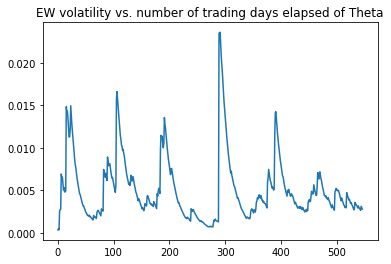

In [8]:
plt.plot((data._RETURNS**2).ewm(halflife=10).mean())
plt.title('EW volatility vs. number of trading days elapsed of Theta')


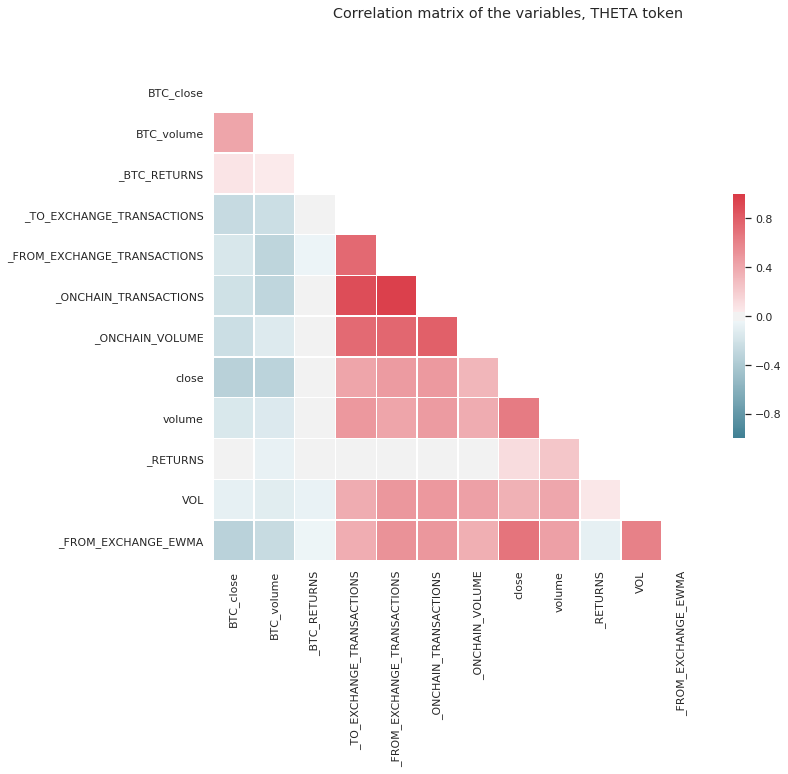

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.suptitle('Correlation matrix of the variables, THETA token')

pass

In [0]:
data = data.loc[~data.isna().any(axis=1)] # drop NaN rows

In [0]:
X = data.drop('VOL', axis=1)
y = data.VOL

In [0]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=2, shuffle=True)

### *) Statistical Significance

In [13]:
# Computation of the F scores for each feature to see which features are statistically significant

from sklearn.feature_selection import f_regression

p_val = f_regression(X, y)[1]
p_val_table = pd.DataFrame({'p_val':p_val,
              'column_name': data.drop(['_RETURNS'], axis=1).columns}).sort_values('p_val')
display('Statistical significance to predict returns^2')
print(p_val_table.to_latex(index=False))

'Statistical significance to predict returns^2'

\begin{tabular}{rl}
\toprule
        p\_val &                  column\_name \\
\midrule
 4.425589e-57 &          \_FROM\_EXCHANGE\_EWMA \\
 1.318101e-35 &  \_FROM\_EXCHANGE\_TRANSACTIONS \\
 1.526385e-33 &        \_ONCHAIN\_TRANSACTIONS \\
 2.823795e-27 &              \_ONCHAIN\_VOLUME \\
 1.143198e-23 &                       volume \\
 2.539673e-20 &    \_TO\_EXCHANGE\_TRANSACTIONS \\
 5.623396e-18 &                        close \\
 9.649668e-03 &                   BTC\_volume \\
 5.304122e-02 &                    BTC\_close \\
 1.077041e-01 &                 \_BTC\_RETURNS \\
 1.599883e-01 &                          VOL \\
\bottomrule
\end{tabular}



In [0]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=2, shuffle=True)

There are too many variables for the model to predict correctly with the amount of data (800 observations). This is called overfitting. We will fit simpler models.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

print('R2 for a Linear Regression with one variable only')
print('=================================================')
def LR_results(variable):

  X = (data.loc[:, variable].values.reshape(-1,1))

  reg = LinearRegression()


  reg.fit(X,y)
  

  return reg.score(X,y)


for variable in data.columns:
  if variable == 'VOL':
    continue
  print(' {:.2f} - {}'.format(LR_results(variable), variable))

R2 for a Linear Regression with one variable only
 0.01 - BTC_close
 0.01 - BTC_volume
 0.00 - _BTC_RETURNS
 0.15 - _TO_EXCHANGE_TRANSACTIONS
 0.25 - _FROM_EXCHANGE_TRANSACTIONS
 0.23 - _ONCHAIN_TRANSACTIONS
 0.19 - _ONCHAIN_VOLUME
 0.13 - close
 0.17 - volume
 0.00 - _RETURNS
 0.37 - _FROM_EXCHANGE_EWMA


In [16]:
df = pd.DataFrame([[0.01, 'BTC_close'],
 [0.00,'BTC_volume'],
 [0.00, '_BTC_RETURNS'],
 [0.15, '_TO_EXCHANGE_TRANSACTIONS'],
 [0.25, '_FROM_EXCHANGE_TRANSACTIONS'],
 [0.23, '_ONCHAIN_TRANSACTIONS'],
 [0.19, '_ONCHAIN_VOLUME'],
 [0.13 ,'close'],
 [0.17, 'volume']])
print(df.to_latex(index=False))

\begin{tabular}{rl}
\toprule
    0 &                            1 \\
\midrule
 0.01 &                    BTC\_close \\
 0.00 &                   BTC\_volume \\
 0.00 &                 \_BTC\_RETURNS \\
 0.15 &    \_TO\_EXCHANGE\_TRANSACTIONS \\
 0.25 &  \_FROM\_EXCHANGE\_TRANSACTIONS \\
 0.23 &        \_ONCHAIN\_TRANSACTIONS \\
 0.19 &              \_ONCHAIN\_VOLUME \\
 0.13 &                        close \\
 0.17 &                       volume \\
\bottomrule
\end{tabular}



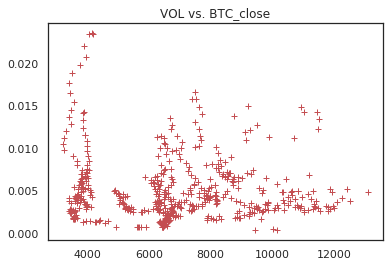

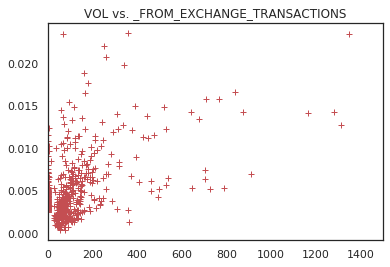

In [17]:
plt.plot(data.BTC_close, data.VOL, 'r+')
plt.title('VOL vs. BTC_close')
plt.figure()
plt.plot(data._FROM_EXCHANGE_TRANSACTIONS, data.VOL, 'r+')
plt.title('VOL vs. _FROM_EXCHANGE_TRANSACTIONS')
plt.xlim((0,1500))
pass

### *) Comparison with Volatility arima model

In [18]:
data

,BTC_close,BTC_volume,_BTC_RETURNS,_TO_EXCHANGE_TRANSACTIONS,_FROM_EXCHANGE_TRANSACTIONS,_ONCHAIN_TRANSACTIONS,_ONCHAIN_VOLUME,close,volume,_RETURNS,VOL,_FROM_EXCHANGE_EWMA
0,9454.60,6.434511e+08,0.102112,20,55,75,4.012353e+24,0.000014,293.24,0.018458,0.000341,3025.000000
1,10029.51,8.262557e+08,0.059030,13,52,65,2.382509e+24,0.000014,455.06,0.024568,0.000477,2858.939720
2,10163.05,6.718616e+08,0.013227,17,74,91,1.821926e+24,0.000014,289.64,-0.012931,0.000366,3792.409413
3,11040.00,7.879111e+08,0.082766,7,43,50,9.719927e+23,0.000015,423.71,0.089839,0.002497,3254.937736
4,10380.06,9.898472e+08,-0.061638,4,128,132,9.691477e+24,0.000016,426.84,0.060275,0.002757,6256.762180
...,...,...,...,...,...,...,...,...,...,...,...,...
542,11307.69,2.940053e+09,-0.049424,0,0,0,0.000000e+00,0.000010,27.61,0.052273,0.002840,11.709477
543,11555.86,2.167326e+09,0.021710,0,0,0,0.000000e+00,0.000010,35.23,-0.000980,0.002650,10.925329
544,11392.42,2.118033e+09,-0.014244,0,0,0,0.000000e+00,0.000011,95.25,0.098869,0.003127,10.193692
545,10893.15,2.791755e+09,-0.044814,0,0,0,0.000000e+00,0.000011,55.61,-0.027004,0.002967,9.511051


In [19]:
data.shape, y.shape

((547, 12), (547,))

In [0]:
r = (data.VOL.shift(1) - data.VOL ) 
r[0]=0

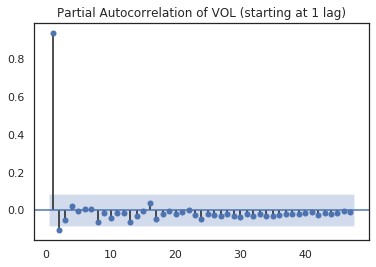

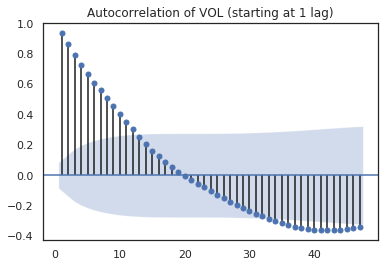

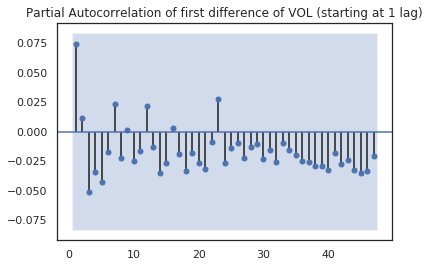

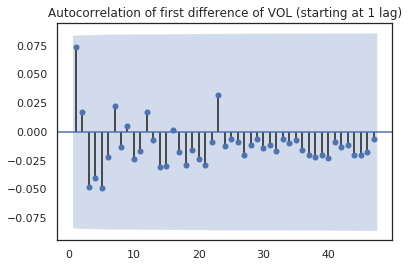

In [21]:
# As the VOL process is clearly integrated we will take the first difference

r = data.VOL
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(r, lags=list(range(1,48)))
plt.title('Partial Autocorrelation of VOL (starting at 1 lag)')
plt.show()
plot_acf(r, lags=list(range(1,48)))
plt.title('Autocorrelation of VOL (starting at 1 lag)')
plt.show()

r = (data.VOL.shift(1) - data.VOL ) 
r[0]=0
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(r, lags=list(range(1,48)))
plt.title('Partial Autocorrelation of first difference of VOL (starting at 1 lag)')
plt.show()
plot_acf(r, lags=list(range(1,48)))
plt.title('Autocorrelation of first difference of VOL (starting at 1 lag)')
plt.show()


In [22]:
# ARIMAX model with the stat significant variables.
import  copy
data_temp = copy.copy(data)
data_temp.loc[:,'_RETURNS_2'] = y**2
df = data_temp
normalized_df=(df-df.mean())/df.std()
model = pf.ARIMAX(data=normalized_df, formula='VOL~1+BTC_close+volume',
                  ar=1,ma=1, integ=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,1,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced VOL                     Method: MLE                                       
Start Date: 1                                           Log Likelihood: -154.8666                         
End Date: 546                                           AIC: 321.7332                                     
Number of observations: 545                             BIC: 347.5379                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    -0.3687    0.0739     -4.9859  0.0      (-0.5136 | -0.2237)      
MA(1)                                

In [23]:
# ARIMAX model with the most correlated variables.
import  copy
data_temp = copy.copy(data)
data_temp.loc[:,'_RETURNS_2'] = y**2
df = data_temp
normalized_df=(df-df.mean())/df.std()
model = pf.ARIMAX(data=normalized_df, formula='VOL~1+_TO_EXCHANGE_TRANSACTIONS+_FROM_EXCHANGE_TRANSACTIONS+BTC_close+volume+_BTC_RETURNS',
                  ar=1,ma=1,integ=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,1,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced VOL                     Method: MLE                                       
Start Date: 1                                           Log Likelihood: -150.4435                         
End Date: 546                                           AIC: 318.887                                      
Number of observations: 545                             BIC: 357.5941                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    -0.3679    0.0875     -4.2058  0.0      (-0.5393 | -0.1964)      
MA(1)                                

In [24]:
# ARIMAX model with the volume.
import  copy
data_temp = copy.copy(data)
data_temp.loc[:,'_RETURNS_2'] = y**2
df = data_temp
normalized_df=(df-df.mean())/df.std()
model = pf.ARIMAX(data=normalized_df, formula='VOL~1+volume',
                  ar=1, ma=1,integ=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,1,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced VOL                     Method: MLE                                       
Start Date: 1                                           Log Likelihood: -156.731                          
End Date: 546                                           AIC: 323.462                                      
Number of observations: 545                             BIC: 344.966                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    -0.3747    0.075      -4.9957  0.0      (-0.5217 | -0.2277)      
MA(1)                                

### *) Random Forest 

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor()

cv = GridSearchCV(rfr, {'n_estimators': [5, 10, 20, 40, 80],
                        'max_depth':[1,2,3,4, 10]})

cv.fit(X,y)



GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [26]:
print('The best Cross validated R2 score is {:.2f}'.format(cv.best_score_))

# The random forest overfit the data.

The best Cross validated R2 score is 0.17


In [27]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

rid = Ridge()
rid.fit(X, y)
print('R^2 train score '+str(rid.score(X,y)))


cv = GridSearchCV(rid, {'alpha': np.logspace(-5,5,10)}, cv=3, )

cv.fit(X,y)
print('The best Cross validated R2 score is {:.2f}'.format(cv.best_score_))



R^2 train score 0.4744540651249146
The best Cross validated R2 score is -2.39
